In [1]:
import warnings
warnings.filterwarnings('ignore')


##Import Libraries

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

##Import Dataset

In [10]:
fname = 'gender-classifier-DFE-791531.csv'


try:
    df = pd.read_csv(fname, encoding='latin-1', engine='python', on_bad_lines='skip')
except UnicodeDecodeError:
    # Fallback to ISO-8859-1 if latin-1 somehow fails
    df = pd.read_csv(fname, encoding='ISO-8859-1', engine='python', on_bad_lines='skip')

print(f"Loaded dataset with shape: {df.shape}")
df.head(3)

Loaded dataset with shape: (20050, 26)


,_unit_id,_golden,_unit_state,_trusted_judgments,_last_judgment_at,gender,gender:confidence,profile_yn,profile_yn:confidence,created,...,profileimage,retweet_count,sidebar_color,text,tweet_coord,tweet_count,tweet_created,tweet_id,tweet_location,user_timezone
0,815719226,False,finalized,3,10/26/15 23:24,male,1.0000,yes,1.0,12/5/13 1:48,...,https://pbs.twimg.com/profile_images/414342229...,0,FFFFFF,Robbie E Responds To Critics After Win Against...,NaN,110964,10/26/15 12:40,6.587300e+17,main; @Kan1shk3,Chennai
1,815719227,False,finalized,3,10/26/15 23:30,male,1.0000,yes,1.0,10/1/12 13:51,...,https://pbs.twimg.com/profile_images/539604221...,0,C0DEED,ÛÏIt felt like they were my friends and I was...,NaN,7471,10/26/15 12:40,6.587300e+17,NaN,Eastern Time (US & Canada)
2,815719228,False,finalized,3,10/26/15 23:33,male,0.6625,yes,1.0,11/28/14 11:30,...,https://pbs.twimg.com/profile_images/657330418...,1,C0DEED,i absolutely adore when louis starts the songs...,NaN,5617,10/26/15 12:40,6.587300e+17,clcncl,Belgrade


##Quick inspect & preprocessing

In [11]:
# columns, types, missing stats
print(df.columns.tolist())
df.info()
df.isnull().sum().sort_values(ascending=False).head(15)


['_unit_id', '_golden', '_unit_state', '_trusted_judgments', '_last_judgment_at', 'gender', 'gender:confidence', 'profile_yn', 'profile_yn:confidence', 'created', 'description', 'fav_number', 'gender_gold', 'link_color', 'name', 'profile_yn_gold', 'profileimage', 'retweet_count', 'sidebar_color', 'text', 'tweet_coord', 'tweet_count', 'tweet_created', 'tweet_id', 'tweet_location', 'user_timezone']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20050 entries, 0 to 20049
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   _unit_id               20050 non-null  int64  
 1   _golden                20050 non-null  bool   
 2   _unit_state            20050 non-null  object 
 3   _trusted_judgments     20050 non-null  int64  
 4   _last_judgment_at      20000 non-null  object 
 5   gender                 19953 non-null  object 
 6   gender:confidence      20024 non-null  float64
 7   profile_yn        

,0
profile_yn_gold,20000
gender_gold,20000
tweet_coord,19891
user_timezone,7798
tweet_location,7485
description,3744
gender,97
_last_judgment_at,50
gender:confidence,26
_unit_id,0


In [12]:
for col in ['created', 'tweet_created']:
    if col in df.columns:
        df[col + '_dt'] = pd.to_datetime(df[col], errors='coerce', infer_datetime_format=True)
df[['created','created_dt','tweet_created','tweet_created_dt']].head()


,created,created_dt,tweet_created,tweet_created_dt
0,12/5/13 1:48,2013-12-05 01:48:00,10/26/15 12:40,2015-10-26 12:40:00
1,10/1/12 13:51,2012-10-01 13:51:00,10/26/15 12:40,2015-10-26 12:40:00
2,11/28/14 11:30,2014-11-28 11:30:00,10/26/15 12:40,2015-10-26 12:40:00
3,6/11/09 22:39,2009-06-11 22:39:00,10/26/15 12:40,2015-10-26 12:40:00
4,4/16/14 13:23,2014-04-16 13:23:00,10/26/15 12:40,2015-10-26 12:40:00


In [13]:
# account age in days (tweet time - profile created)
if 'created_dt' in df.columns and 'tweet_created_dt' in df.columns:
    df['account_age_days'] = (df['tweet_created_dt'] - df['created_dt']).dt.days

# ensure numeric columns exist
for col in ['fav_number','retweet_count','tweet_count','gender:confidence','profile_yn:confidence']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# weekday of tweet
if 'tweet_created_dt' in df.columns:
    df['tweet_weekday'] = df['tweet_created_dt'].dt.day_name()


##Set plotting style and palettes:

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', context='notebook')


##Gender distribution

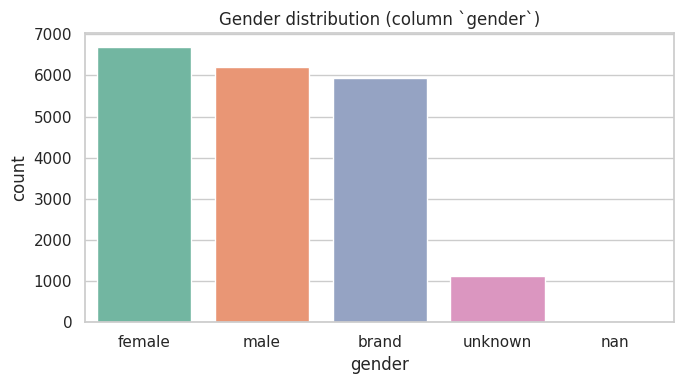

In [15]:
plt.figure(figsize=(7,4))
order = df['gender'].value_counts(dropna=False).index
palette = sns.color_palette("Set2", n_colors=len(order))
sns.countplot(data=df, x='gender', order=order, palette=palette)
plt.title('Gender distribution (column `gender`)')
plt.xlabel('gender')
plt.ylabel('count')
plt.tight_layout()
plt.show()


##Tweet counts distribution

Text(0.5, 1.0, 'tweet_count distribution')

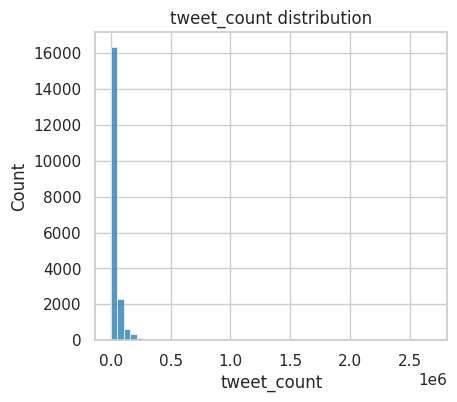

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(df['tweet_count'].dropna(), bins=50, kde=False, color='tab:blue')
plt.title('tweet_count distribution')




##Simple numeric correlation heatmap

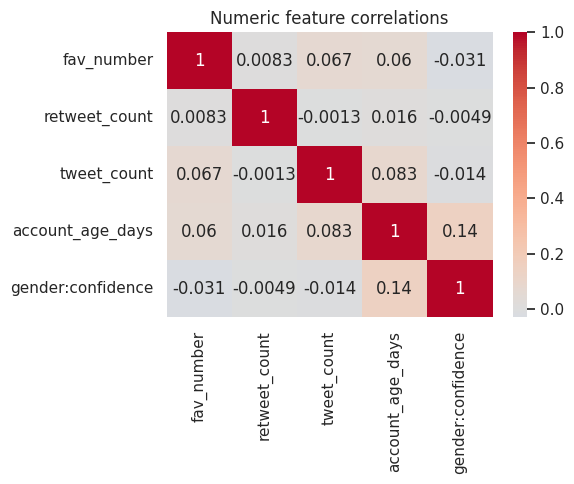

In [20]:
numcols = ['fav_number','retweet_count','tweet_count','account_age_days','gender:confidence']
numcols = [c for c in numcols if c in df.columns]
plt.figure(figsize=(6,5))
sns.heatmap(df[numcols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Numeric feature correlations')
plt.tight_layout(); plt.show()


##Profile vs not

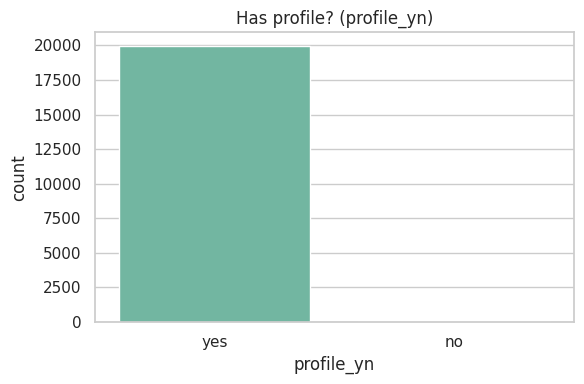

In [26]:
plt.figure(figsize=(6,4))
palette = ['#66c2a5','#fc8d62']
sns.countplot(data=df, x='profile_yn', palette=palette, order=['yes','no'])
plt.title('Has profile? (profile_yn)')
plt.tight_layout(); plt.show()



##Sentiment analysis

In [23]:
!pip install vaderSentiment


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.2 MB/s eta 0:00:00


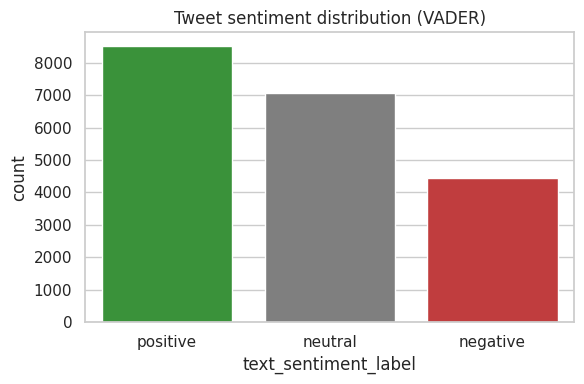

In [24]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

def vader_sentiment(s):
    if pd.isna(s): return None
    score = analyzer.polarity_scores(str(s))
    return score['compound']

df['text_sentiment'] = df['text'].apply(vader_sentiment) if 'text' in df.columns else None
# sentiment label
def label_sent(x):
    if x is None or pd.isna(x): return 'missing'
    if x >= 0.05: return 'positive'
    if x <= -0.05: return 'negative'
    return 'neutral'

if 'text_sentiment' in df.columns:
    df['text_sentiment_label'] = df['text_sentiment'].apply(label_sent)
    plt.figure(figsize=(6,4))
    pal = {'positive':'#2ca02c','neutral':'#7f7f7f','negative':'#d62728'}
    sns.countplot(data=df, x='text_sentiment_label', order=['positive','neutral','negative'], palette=pal)
    plt.title('Tweet sentiment distribution (VADER)')
    plt.tight_layout(); plt.show()


##Sentiment by weekday

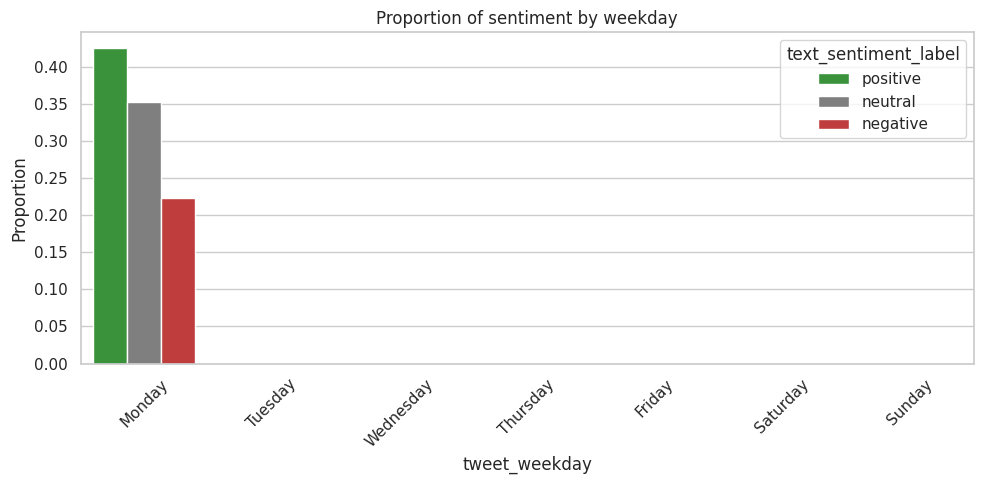

In [25]:
if 'tweet_weekday' in df.columns and 'text_sentiment_label' in df.columns:
    plt.figure(figsize=(10,5))
    # a grouped bar chart: percent positive/neutral/negative per weekday
    weekday_order = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
    tmp = (df.dropna(subset=['tweet_weekday','text_sentiment_label'])
           .groupby(['tweet_weekday','text_sentiment_label']).size().reset_index(name='count'))
    # normalize by weekday
    denom = tmp.groupby('tweet_weekday')['count'].transform('sum')
    tmp['pct'] = tmp['count'] / denom
    sns.barplot(data=tmp, x='tweet_weekday', y='pct', hue='text_sentiment_label',
                hue_order=['positive','neutral','negative'], order=weekday_order, palette=pal)
    plt.ylabel('Proportion')
    plt.title('Proportion of sentiment by weekday')
    plt.xticks(rotation=45)
    plt.tight_layout(); plt.show()
